In [ ]:
import os
import re
import cv2
import shutil
import random
import tarfile
import zipfile
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.random import seed
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.utils import dataset_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
random_seed = 42

seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
with zipfile.ZipFile("/content/gdrive/MyDrive/Progetto_AML/Datasets/CelebA-HQ-256.zip","r") as zip_ref:
    zip_ref.extractall()  
with zipfile.ZipFile("/content/gdrive/MyDrive/Progetto_AML/Datasets/ddpm_1000_inference_results.zip","r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("/content/gdrive/MyDrive/Progetto_AML/Datasets/ddim_50_inference_results.zip","r") as zip_ref:
    zip_ref.extractall()  

Mounted at /content/gdrive


In [ ]:
image_size = (299, 299)

In [ ]:
real_data_dir = pathlib.Path('/content/celeba_hq_256/')
seed_ds = 42 
shuffle_value = False
batch_size = 1

real_ds = tf.keras.preprocessing.image_dataset_from_directory(
    real_data_dir,
    labels=None,
    seed=seed_ds,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle_value)

Found 30000 files belonging to 1 classes.


In [ ]:
ddpm_data_dir = pathlib.Path('/content/ddpm_1000_inference_results/')
seed_ds = 42 
shuffle_value = False
batch_size = 1

ddpm_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ddpm_data_dir,
    labels=None,
    seed=seed_ds,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle_value)

Found 100 files belonging to 1 classes.


In [ ]:
ddim_data_dir = pathlib.Path('/content/ddim_50_inference_results/')
seed_ds = 42 
shuffle_value = False
batch_size = 1

ddim_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ddim_data_dir,
    labels=None,
    seed=seed_ds,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle_value)

Found 100 files belonging to 1 classes.


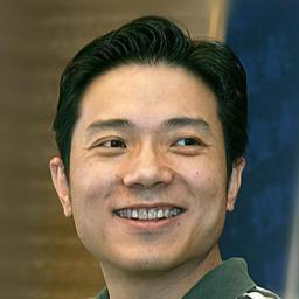

In [ ]:
image_real = image.load_img("/content/celeba_hq_256/00000.jpg", target_size=image_size)
image_real

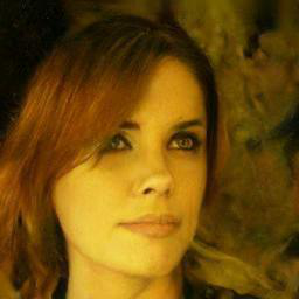

In [ ]:
image_ddpm = image.load_img("/content/ddpm_1000_inference_results/0.jpg", target_size=image_size)
image_ddpm

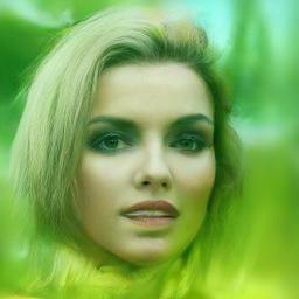

In [ ]:
image_ddim = image.load_img("/content/ddim_50_inference_results/0.jpg", target_size=image_size)
image_ddim

In [ ]:
def preprocess(images):
  return preprocess_input(images)

real_ds_preprocessed = real_ds.map(preprocess)
ddpm_ds_preprocessed = ddpm_ds.map(preprocess)
ddim_ds_preprocessed = ddim_ds.map(preprocess)

# Creazione modello

In [ ]:
model = InceptionV3(weights='imagenet')
model.summary()

96112376/96112376 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
for layer in model.layers:
  layer.trainable = False

feat_extractor_model = Model(inputs=model.input, 
                             outputs=model.get_layer('avg_pool').output)
feat_extractor_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
features_real_data = feat_extractor_model.predict(real_ds_preprocessed)
print(features_real_data.shape)

30000/30000 [==============================] - 455s 15ms/step
(30000, 2048)


In [ ]:
paths = real_ds.file_paths

In [ ]:
knn = NearestNeighbors(n_neighbors=5, 
                       algorithm='brute',
                       metric='minkowski',
                       p=2)
knn.fit(features_real_data)

NearestNeighbors(algorithm='brute')

# Valutazione soggettiva similarity retrieval per DDPM

In [ ]:
#features_ddpm_data = feat_extractor_model.predict(ddpm_ds_preprocessed)
#print(features_ddpm_data.shape)

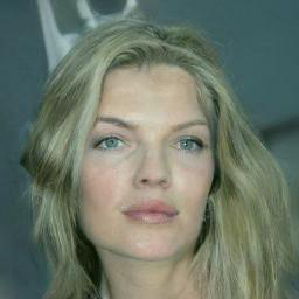

In [ ]:
img_path = "/content/ddpm_1000_inference_results/2.jpg"
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

im_query = image.load_img(img_path, target_size=image_size)
im_query

In [ ]:
features_new_image = feat_extractor_model.predict(img)
print(features_new_image.shape)

1/1 [==============================] - 0s 63ms/step
(1, 2048)


In [ ]:
features_new_image

array([[0.20433691, 0.40158924, 0.04311327, ..., 0.45740154, 0.08429527,
        0.24070656]], dtype=float32)

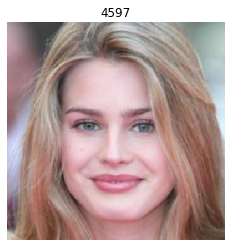

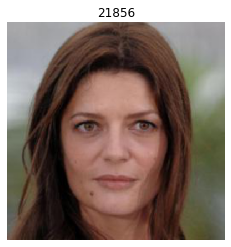

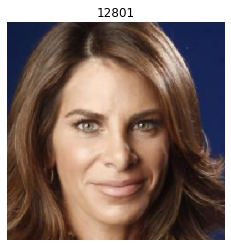

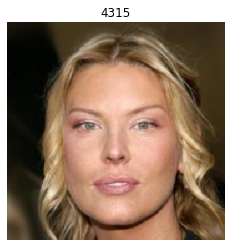

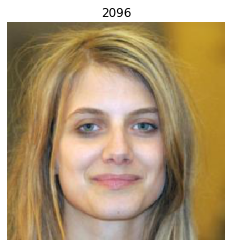

In [ ]:
# Il primo array indica le distanze
# Il secondo array specifica gli indici delle immagini recuperate
closest_distances, indices = knn.kneighbors(features_new_image, n_neighbors=5)

for i in range(5):
  path_plot = paths[indices[0,i]]
  
  img = image.load_img(path_plot, target_size=image_size)

  plt.figure()
  plt.title(indices[0,i])
  plt.imshow(img)
  plt.axis('off')

# Valutazione soggettiva similarity retrieval per DDIM

In [ ]:
#features_ddim_data = feat_extractor_model.predict(ddim_ds_preprocessed)
#print(features_ddim_data.shape)

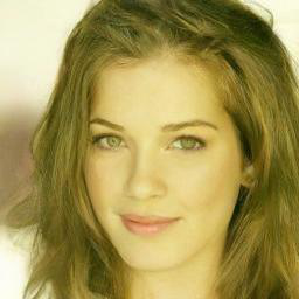

In [ ]:
img_path = "/content/ddim_50_inference_results/3.jpg"
img = image.load_img(img_path, target_size=image_size)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

im_query = image.load_img(img_path, target_size=image_size)
im_query

In [ ]:
features_new_image = feat_extractor_model.predict(img)
print(features_new_image.shape)

1/1 [==============================] - 0s 33ms/step
(1, 2048)


In [ ]:
features_new_image

array([[0.05651851, 0.35460284, 0.0545731 , ..., 0.6406002 , 0.04369793,
        0.5340817 ]], dtype=float32)

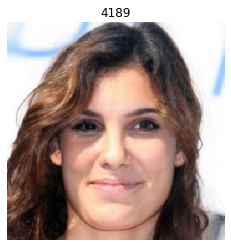

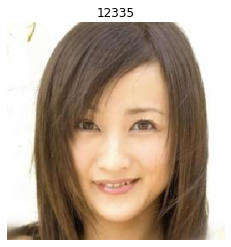

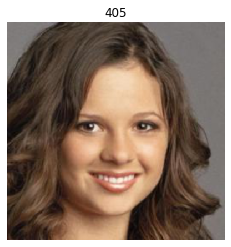

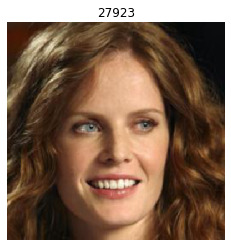

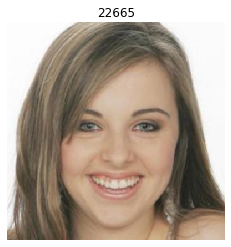

In [ ]:
# Il primo array indica le distanze
# Il secondo array specifica gli indici delle immagini recuperate
closest_distances, indices = knn.kneighbors(features_new_image, n_neighbors=5)

for i in range(5):
  path_plot = paths[indices[0,i]]
  
  img = image.load_img(path_plot, target_size=image_size)
 
  plt.figure()
  plt.title(indices[0,i])
  plt.imshow(img)
  plt.axis('off')